### Student information:
- Name: Vineet Kumar
- Roll No.: 2024AC05100
- Assignment-1: Video Classification

### Objective 1: (Classical Models)
Perform comparative analysis of classical machine learning models for video action classification. 

The goal is to evaluate and contrast different approaches in terms of predictive performance, computational efficiency, and interpretability.

Classical Models compared:
- Support Vector Machine (SVM)
- Random Forest
- k-Nearest Neighbors (k-NN)
- Logistic Regression
- Gradient Boosting.

### Objective 2: (Deep Learning Models)
Perform comparative analysis of deep learning models for video action classification. 

The goal is to evaluate and contrast different approaches in terms of predictive performance, computational efficiency, and interpretability.

Deep Learning Models compared:
- 2D-CNN - with temporal pooling (ResNet18 pretrained on ImageNet)
- 3D-CNN - pre-trained 3D ResNet-18 (R3D-18), which is an I3D-style 3D CNN architecture



### Environment Setup

Before running this notebook, install dependencies using:
> `pip install -r requirements.txt`

- (Ignore if already done)


> importing modules

In [1]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import os;
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc;
from sklearn.preprocessing import label_binarize;
from sklearn.metrics import ConfusionMatrixDisplay;

from sklearn.model_selection import train_test_split;
from sklearn.base import clone;
import joblib;
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
import warnings
import tracemalloc
import json

from models import ResNet18Temporal, ResNet3D
import torch
from torch.utils.data import Subset
from data_loader import VideoDataset2D
from data_loader import VideoDataset3D
from torchvision import transforms
from torch.utils.data import DataLoader

c:\Users\vinkumar84\Documents\learning\bits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Additional tuning for better and clean results

In [2]:
# Supressing unnecessry warnings.
warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42);

> Creating required directories to save the results

In [3]:
os.makedirs("../results/feature_visualizations/tsne_umap/", exist_ok=True); 
os.makedirs("../results/performance_plots/", exist_ok=True);
os.makedirs("../results/performance_plots/classical", exist_ok=True);
os.makedirs("../results/feature_visualizations/tsne_umap", exist_ok=True)

> Loading saved results from Part-A (Classical Models)

In [4]:
# ===================================================
# Load saved results from Part-A (classical models)
# ===================================================

y_test = np.load("../results/final_classical_y_test.npy");

svm_test_pred = np.load("../results/stats_classical/svm_test_pred.npy");
rf_test_pred  = np.load("../results/stats_classical/rf_test_pred.npy");
knn_test_pred = np.load("../results/stats_classical/knn_test_pred.npy");
logreg_test_pred  = np.load("../results/stats_classical/logreg_test_pred.npy");
gb_test_pred  = np.load("../results/stats_classical/gb_test_pred.npy");

svm_train_time = np.load("../results/stats_classical/svm_train_time.npy");
rf_train_time  = np.load("../results/stats_classical/rf_train_time.npy");
knn_train_time = np.load("../results/stats_classical/knn_train_time.npy");
logreg_train_time  = np.load("../results/stats_classical/logreg_train_time.npy");
gb_train_time  = np.load("../results/stats_classical/gb_train_time.npy");

svm_test_time = np.load("../results/stats_classical/svm_test_time.npy");
rf_test_time  = np.load("../results/stats_classical/rf_test_time.npy");
knn_test_time = np.load("../results/stats_classical/knn_test_time.npy");
logreg_test_time  = np.load("../results/stats_classical/logreg_test_time.npy");
gb_test_time  = np.load("../results/stats_classical/gb_test_time.npy");

svm_acc = np.load("../results/stats_classical/svm_accuracy.npy");
rf_acc  = np.load("../results/stats_classical/rf_accuracy.npy");
knn_acc = np.load("../results/stats_classical/knn_accuracy.npy");
logreg_acc  = np.load("../results/stats_classical/logreg_accuracy.npy");
gb_acc  = np.load("../results/stats_classical/gb_accuracy.npy");

svm_f1 = np.load("../results/stats_classical/svm_f1.npy");
rf_f1  = np.load("../results/stats_classical/rf_f1.npy");
knn_f1 = np.load("../results/stats_classical/knn_f1.npy");
logreg_f1  = np.load("../results/stats_classical/logreg_f1.npy");
gb_f1  = np.load("../results/stats_classical/gb_f1.npy");

best_svm = joblib.load("../results/saved_models/classical/svm_trained_model.joblib");
best_rf = joblib.load("../results/saved_models/classical/rf_trained_model.joblib");
best_knn = joblib.load("../results/saved_models/classical/knn_trained_model.joblib");
logreg = joblib.load("../results/saved_models/classical/logreg_trained_model.joblib");
gb = joblib.load("../results/saved_models/classical/gb_trained_model.joblib");

X_train = np.load("../results/saved_feature_matrices/X_train.npy");
X_val   = np.load("../results/saved_feature_matrices/X_val.npy");
X_test  = np.load("../results/saved_feature_matrices/X_test.npy");

y_train = np.load("../results/saved_feature_matrices/y_train.npy");
y_val   = np.load("../results/saved_feature_matrices/y_val.npy");
y_test  = np.load("../results/saved_feature_matrices/y_test.npy");

X_test_rf   = np.load("../results/stats_classical/X_test_rf.npy");

### Classical models: Evaluation Metrices Comparison

1. Classical models: Highlighting the best model

In [5]:
models = ["SVM", "Random Forest", "k-NN", "Logistic Regression", "Gradient Boosting"];
preds = [svm_test_pred, rf_test_pred, knn_test_pred, logreg_test_pred, gb_test_pred];

acc_list = [];
prec_list = [];
rec_list = [];
f1_list = [];

for p in preds:
    acc_list.append(accuracy_score(y_test, p));
    prec_list.append(precision_score(y_test, p, average="macro"));
    rec_list.append(recall_score(y_test, p, average="macro"));
    f1_list.append(f1_score(y_test, p, average="macro"));

# Create comparison dataframe
perf_df = pd.DataFrame({
    "Model": models,
    "Accuracy": acc_list,
    "Precision": prec_list,
    "Recall": rec_list,
    "F1-score": f1_list
});


perf_df

# Printing the table and Highlighting the best model
def highlight_best(s):
    is_best = s == s.max();
    return ["background-color: red" if v else "" for v in is_best];

perf_df.style.apply(highlight_best, subset=["Accuracy","Precision","Recall","F1-score"])

,Model,Accuracy,Precision,Recall,F1-score
0,SVM,0.913043,0.944444,0.897436,0.912885
1,Random Forest,0.956522,0.955556,0.966667,0.958647
2,k-NN,0.847826,0.839683,0.838462,0.838272
3,Logistic Regression,0.695652,0.683455,0.676923,0.679650
4,Gradient Boosting,0.978261,0.984127,0.974359,0.978537


2. Classical models: Accuracy Comparison Plot

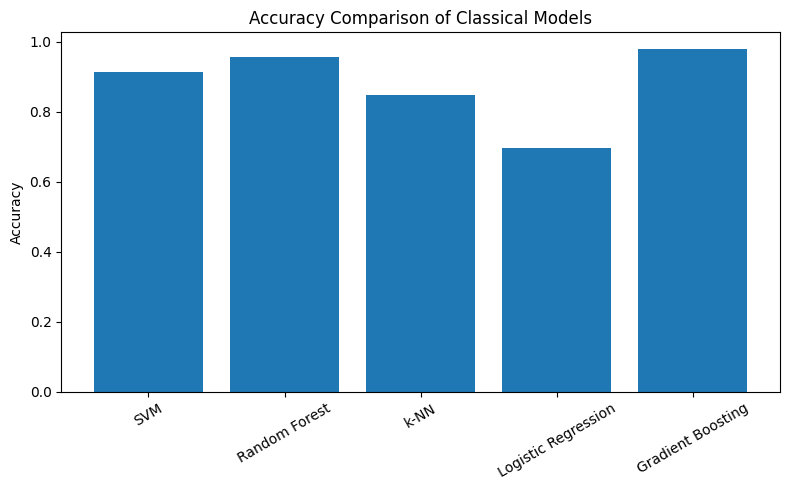

In [6]:
plt.figure(figsize=(8,5));
plt.bar(perf_df["Model"], perf_df["Accuracy"]);
plt.xticks(rotation=30)
plt.ylabel("Accuracy");
plt.title("Accuracy Comparison of Classical Models");
plt.tight_layout();
plt.savefig("../results/performance_plots/classical/accuracy_comparison.png", dpi=300);
plt.show();



3. Classical models: F1-Score Comparison Plot

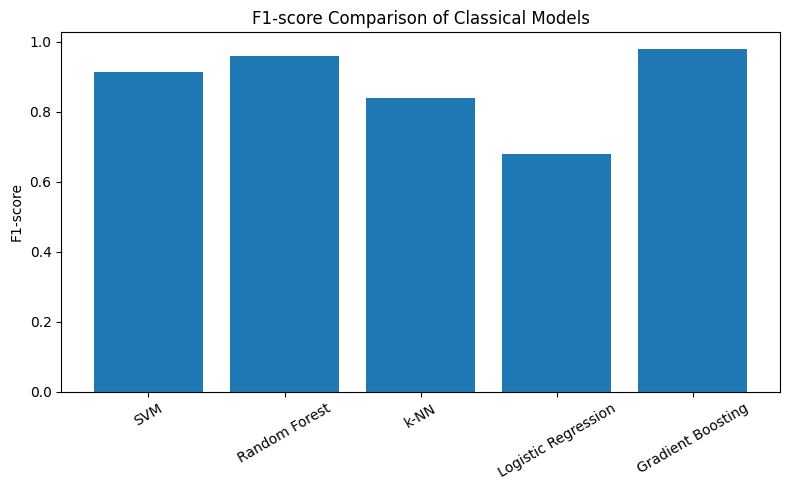

In [7]:
plt.figure(figsize=(8,5));
plt.bar(perf_df["Model"], perf_df["F1-score"]);
plt.xticks(rotation=30);
plt.ylabel("F1-score");
plt.title("F1-score Comparison of Classical Models");
plt.tight_layout();
plt.savefig("../results/performance_plots/classical/f1_score_comparison.png", dpi=300);
plt.show();


4. Classical models: Precision and Recall grouped plot

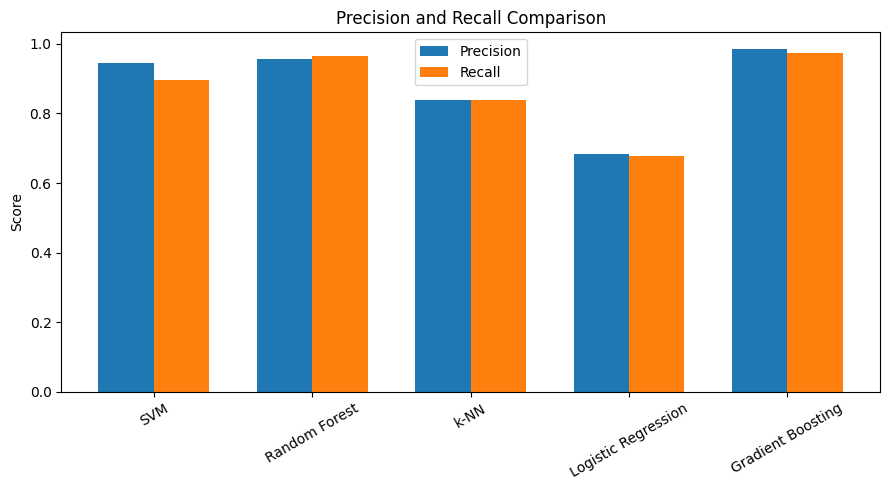

In [8]:
x = np.arange(len(perf_df));
width = 0.35;

plt.figure(figsize=(9,5));
plt.bar(x - width/2, perf_df["Precision"], width, label="Precision");
plt.bar(x + width/2, perf_df["Recall"], width, label="Recall");

plt.xticks(x, perf_df["Model"], rotation=30);
plt.ylabel("Score");
plt.title("Precision and Recall Comparison");
plt.legend();
plt.tight_layout();
plt.savefig("../results/performance_plots/classical/precision_recall_comparison.png", dpi=300);
plt.show();


5. Classical models: ROC multiclass comparison

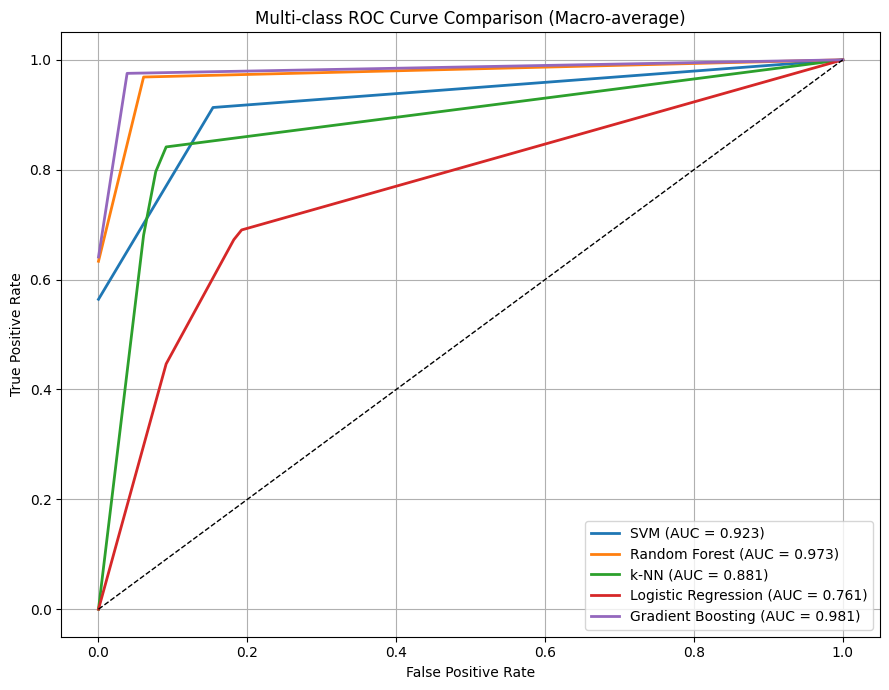

In [9]:
# Class labels (0,1,2)
classes = np.unique(y_test);
n_classes = len(classes);

# Binarize true labels
y_test_bin = label_binarize(y_test, classes=classes);

models = ["SVM", "Random Forest", "k-NN", "Logistic Regression", "Gradient Boosting"];
preds = [svm_test_pred, rf_test_pred, knn_test_pred, logreg_test_pred, gb_test_pred];

os.makedirs("../results/performance_plots", exist_ok=True);

plt.figure(figsize=(9,7));

for model_name, y_pred in zip(models, preds):
    
    # Binarize predictions
    y_pred_bin = label_binarize(y_pred, classes=classes);
    
    fpr = dict();
    tpr = dict();
    roc_auc = dict();
    
    # ROC per class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i]);
        roc_auc[i] = auc(fpr[i], tpr[i]);
    
    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]));
    mean_tpr = np.zeros_like(all_fpr);

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]);

    mean_tpr /= n_classes;
    macro_auc = auc(all_fpr, mean_tpr);

    plt.plot(all_fpr, mean_tpr, lw=2,
             label=f"{model_name} (AUC = {macro_auc:.3f})");

# Random guess line
plt.plot([0, 1], [0, 1], "k--", lw=1);

plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.title("Multi-class ROC Curve Comparison (Macro-average)");
plt.legend(loc="lower right");
plt.grid(True);
plt.tight_layout();
plt.savefig("../results/performance_plots/classical/roc_auc_comparison.png", dpi=300);
plt.show();

6. Classical models: Confusion matrix comparision

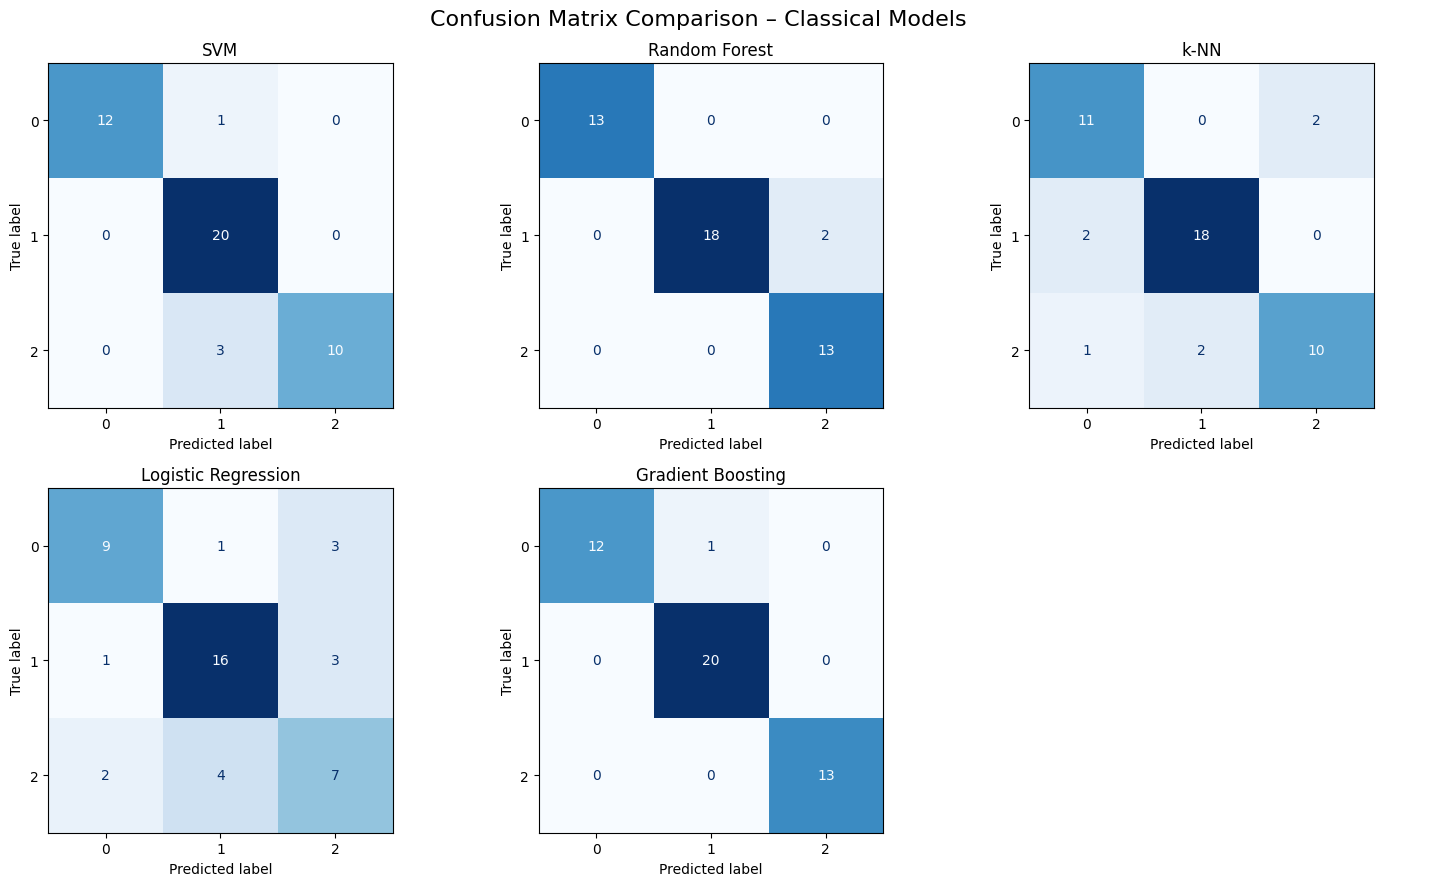

In [10]:
models = ["SVM", "Random Forest", "k-NN", "Logistic Regression", "Gradient Boosting"];
preds = [svm_test_pred, rf_test_pred, knn_test_pred, logreg_test_pred, gb_test_pred];

os.makedirs("../results/performance_plots", exist_ok=True);

fig, axes = plt.subplots(2, 3, figsize=(15, 9));
axes = axes.ravel();

for i, (name, y_pred) in enumerate(zip(models, preds)):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        ax=axes[i],
        cmap="Blues",
        colorbar=False
    );
    axes[i].set_title(name);

axes[-1].axis("off");

fig.suptitle("Confusion Matrix Comparison – Classical Models", fontsize=16);
plt.tight_layout();
plt.subplots_adjust(top=0.92);

plt.savefig("../results/performance_plots/classical/confusion_matrix_comparison.png", dpi=300);
plt.show();

### Classical models: Comparative Analysis

1. Classical models: Training time comparison

In [11]:
# ===================================================
# Computational Efficiency: Training Time Comparison
# ===================================================
models = ["SVM", "Random Forest", "k-NN", "Logistic Regression", "Gradient Boosting"]
train_times = [
    svm_train_time, 
    rf_train_time, 
    knn_train_time, 
    logreg_train_time, 
    gb_train_time
];

# Create dataframe for display
train_time_df = pd.DataFrame({
    "Model": models,
    "Training Time (seconds)": train_times
});

train_time_df

,Model,Training Time (seconds)
0,SVM,63.28010709991213
1,Random Forest,0.16814740002155304
2,k-NN,1.6358784000622109
3,Logistic Regression,1.3486586000071838
4,Gradient Boosting,285.3777647999814


- Plot: Training time comparison (Classical Models)

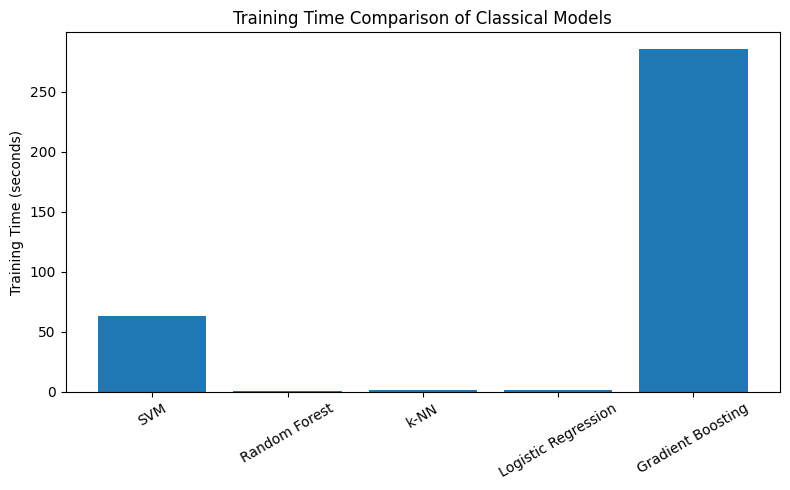

In [12]:
plt.figure(figsize=(8,5));
plt.bar(models, train_times);
plt.xticks(rotation=30);
plt.ylabel("Training Time (seconds)");
plt.title("Training Time Comparison of Classical Models");
plt.tight_layout();
plt.savefig("../results/performance_plots/classical/training_time_comparison.png", dpi=300);
plt.show();


2. Classical models: Inference time per video

In [13]:
# ============================================
# Inference Time per Video (seconds)
# ============================================

num_test_videos = len(y_test)

inf_times = [
    svm_test_time / num_test_videos,
    rf_test_time / num_test_videos,
    knn_test_time / num_test_videos,
    logreg_test_time / num_test_videos,
    gb_test_time / num_test_videos
]

models = ["SVM", "Random Forest", "k-NN", "Logistic Regression", "Gradient Boosting"]

inf_df = pd.DataFrame({
    "Model": models,
    "Inference Time per Video (s)": inf_times
})

inf_df


,Model,Inference Time per Video (s)
0,SVM,0.040232
1,Random Forest,0.000526
2,k-NN,0.000656
3,Logistic Regression,0.000568
4,Gradient Boosting,0.000330


- Plot: Inference time per video (Classical Models)

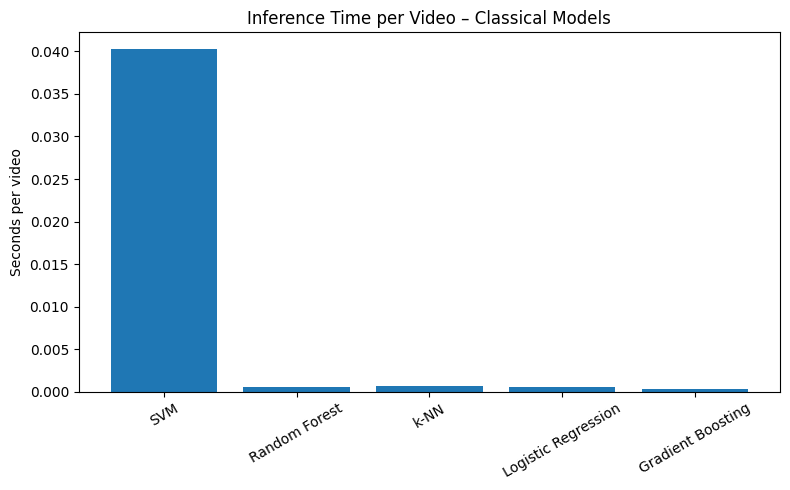

In [14]:
# ============================================
# Plot: Inference time per video
# ============================================

os.makedirs("../results/performance_plots", exist_ok=True);

plt.figure(figsize=(8,5));
plt.bar(inf_df["Model"], inf_df["Inference Time per Video (s)"]);
plt.xticks(rotation=30);
plt.ylabel("Seconds per video");
plt.title("Inference Time per Video – Classical Models");
plt.tight_layout();
plt.savefig("../results/performance_plots/classical/inference_time_comparison.png", dpi=300);
plt.show();


3. Classical models: Model Size Comparison

In [15]:
# ============================================
# Model Size (Disk footprint in MB)
# ============================================

model_files = {
    "SVM": "../results/saved_models/classical/svm_trained_model.joblib",
    "Random Forest": "../results/saved_models/classical/rf_trained_model.joblib",
    "k-NN": "../results/saved_models/classical/knn_trained_model.joblib",
    "Logistic Regression": "../results/saved_models/classical/logreg_trained_model.joblib",
    "Gradient Boosting": "../results/saved_models/classical/gb_trained_model.joblib"
};

sizes = [];

for model, path in model_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024);
        sizes.append([model, size_mb]);
    else:
        sizes.append([model, np.nan]);

size_df = pd.DataFrame(sizes, columns=["Model", "Model Size (MB)"]);
size_df

,Model,Model Size (MB)
0,SVM,166.907628
1,Random Forest,0.723405
2,k-NN,8.087814
3,Logistic Regression,6.884599
4,Gradient Boosting,0.180549


- Plot: Model size comparison (Classical Models)

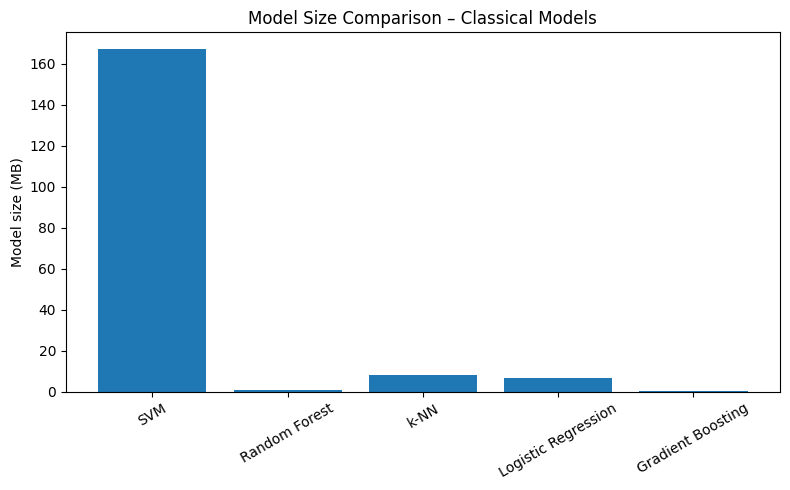

In [16]:
# ============================================
# Plot: Model size comparison
# ============================================

plt.figure(figsize=(8,5));
plt.bar(size_df["Model"], size_df["Model Size (MB)"]);
plt.xticks(rotation=30);
plt.ylabel("Model size (MB)");
plt.title("Model Size Comparison – Classical Models");
plt.tight_layout();
plt.savefig("../results/performance_plots/classical/model_size_comparison.png", dpi=300);
plt.show();

4. Classical models: Data Efficiency Analysis

- This step will take around 15 minutes to complete.

In [17]:
# Defining data splits

#fractions = [0.1, 0.3, 0.5, 0.7, 1.0];
fractions = [0.1, 0.25, 0.5, 0.75, 0.9]


# Store original full training data

X_full = np.vstack([X_train, X_val]);
y_full = np.hstack([y_train, y_val]);


models = {
    "SVM": best_svm,
    "Random Forest": best_rf,
    "k-NN": best_knn,
    "Logistic Regression": logreg,
    "Gradient Boosting": gb
};

# Computing learning curves:
learning_results = {name: [] for name in models}

for i, frac in enumerate(fractions):

    print(f"\n========== Training with {int(frac*100)}% data ==========")

    X_sub, _, y_sub, _ = train_test_split(
        X_full, y_full,
        train_size=frac,
        stratify=y_full,
        random_state=42
    )

    for name, model in tqdm(models.items(),
                             desc=f"Models @ {int(frac*100)}%",
                             position=0,
                             leave=True):

        temp_model = clone(model)
        temp_model.fit(X_sub, y_sub)

        preds = temp_model.predict(X_test)
        acc = accuracy_score(y_test, preds)

        learning_results[name].append(acc)


========== Training with 10% data ==========


Models @ 10%: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]



========== Training with 25% data ==========


Models @ 25%: 100%|██████████| 5/5 [00:55<00:00, 11.12s/it]



========== Training with 50% data ==========


Models @ 50%: 100%|██████████| 5/5 [02:05<00:00, 25.10s/it]



========== Training with 75% data ==========


Models @ 75%: 100%|██████████| 5/5 [03:29<00:00, 41.81s/it]



========== Training with 90% data ==========


Models @ 90%: 100%|██████████| 5/5 [04:18<00:00, 51.61s/it]


- Plot: Learning curves comparison (Classical Models)

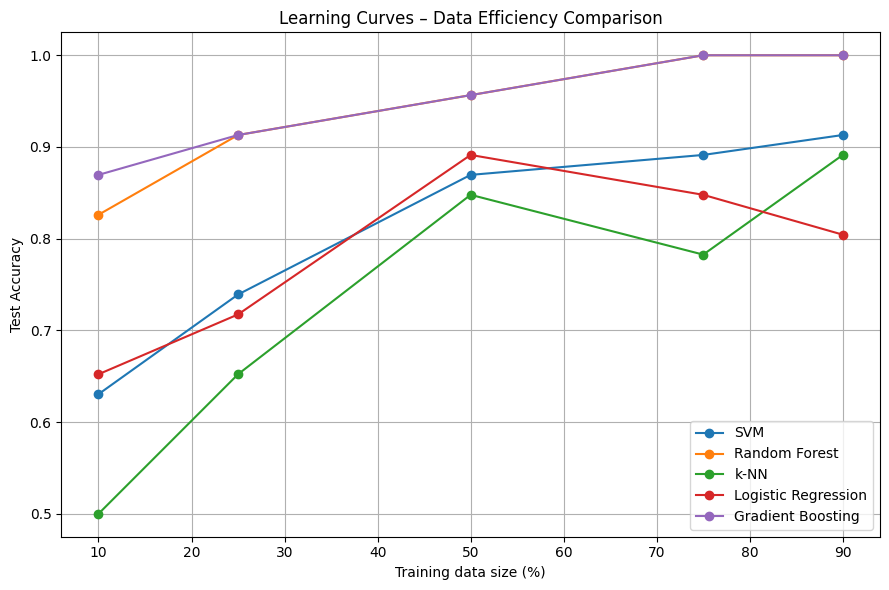

In [18]:
# Plotting the learning curves
plt.figure(figsize=(9,6))

for name, accs in learning_results.items():
    plt.plot([int(f*100) for f in fractions], accs, marker="o", label=name)

plt.xlabel("Training data size (%)")
plt.ylabel("Test Accuracy")
plt.title("Learning Curves – Data Efficiency Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/performance_plots/classical/data_efficiency_learning_curves.png", dpi=300)
plt.show()

5. Classical models: Memory requirements

In [19]:
memory_results = []

models = {
    "SVM": best_svm,
    "Random Forest": best_rf,
    "k-NN": best_knn,
    "Logistic Regression": logreg,
    "Gradient Boosting": gb
};

for name, model in models.items():
    tracemalloc.start()

    if name == "Random Forest":
        _ = model.predict(X_test_rf)
    else:
        _ = model.predict(X_test)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    memory_results.append([name, peak/(1024*1024)]) # MB

memory_df = pd.DataFrame(memory_results, columns=["Model", "Peak Memory Usage (MB)"])
memory_df

,Model,Peak Memory Usage (MB)
0,SVM,26.958426
1,Random Forest,0.286884
2,k-NN,26.957661
3,Logistic Regression,26.957880
4,Gradient Boosting,13.198128


- Plot: Memory requirements (Classical Models)

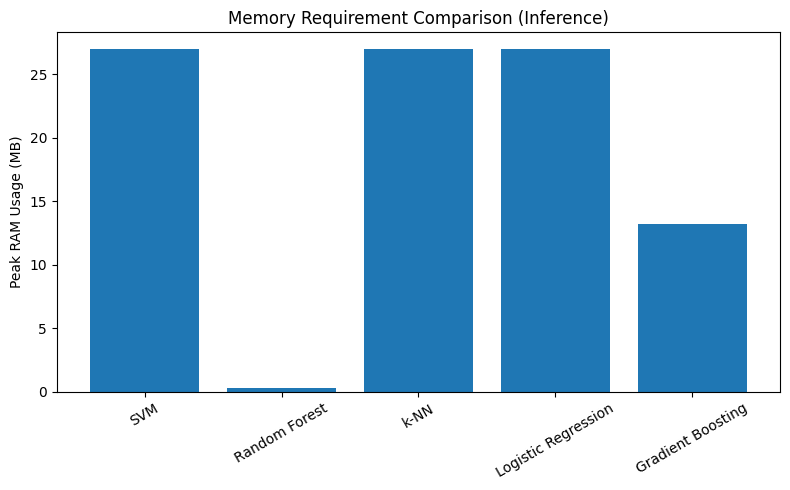

In [20]:
plt.figure(figsize=(8,5))
plt.bar(memory_df["Model"], memory_df["Peak Memory Usage (MB)"])
plt.xticks(rotation=30)
plt.ylabel("Peak RAM Usage (MB)")
plt.title("Memory Requirement Comparison (Inference)")
plt.tight_layout()
plt.savefig("../results/performance_plots/classical/memory_usage_comparison.png", dpi=300)
plt.show()

6. Classical models: t-SNE Visualization (Feature Analysis)

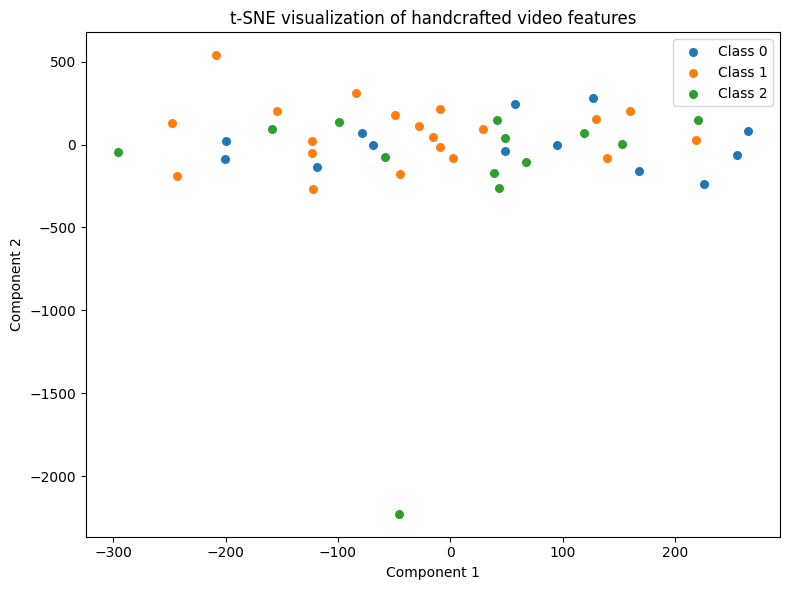

In [21]:

# -------- Normalize features (important for t-SNE) --------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)

# -------- Run t-SNE --------
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1500,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

# -------- Plot --------
plt.figure(figsize=(8,6))

for label in np.unique(y_test):
    idx = y_test == label
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=30, label=f"Class {label}")

plt.title("t-SNE visualization of handcrafted video features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()

plt.savefig("../results/feature_visualizations/tsne_umap/tsne_classical.png", dpi=300)
plt.show()
plt.close()


7. Classical models: UMAP Visualization (Feature Analysis)

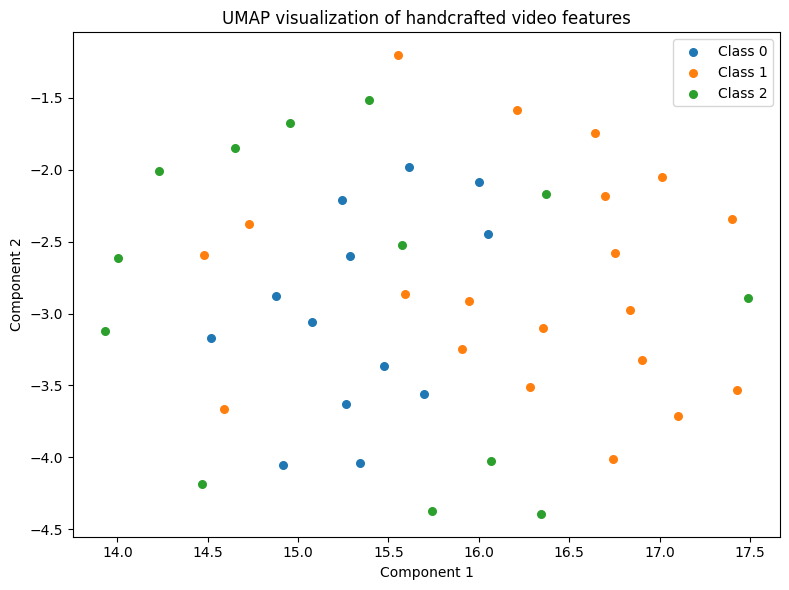

In [22]:


# -------- Run UMAP --------
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

# -------- Plot --------
plt.figure(figsize=(8,6))

for label in np.unique(y_test):
    idx = y_test == label
    plt.scatter(X_umap[idx,0], X_umap[idx,1], s=30, label=f"Class {label}")

plt.title("UMAP visualization of handcrafted video features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.tight_layout()

plt.savefig("../results/feature_visualizations/tsne_umap/umap_classical.png", dpi=300)
plt.show()
plt.close()

___________________________________________________________________________________________________________

### Deep Learning models: Evaluation Metrices Comparison

This section compares the performance of deep learning-based video classification approaches:
1. 2D CNN with Temporal Pooling (ResNet-18)
2. 3D CNN (I3D-style ResNet-3D)

The models are compared based on accuracy, precision, recall, F1-score, inference time, and model size.


> Loading json files and saved results from Part-B (Deep Learning Models)

In [23]:
# Opening stats_2d.json file containing 2D-CNN related data.
with open("../results/stats_deep_learning/stats_2d.json") as f:
    stats_2d = json.load(f)

# Opening stats_3d.json file containing 3D-CNN related data.
with open("../results/stats_deep_learning/stats_3d.json") as f:
    stats_3d = json.load(f)

deep_learning_results = {
    "2D CNN (ResNet18)": stats_2d,
    "3D CNN (ResNet3D)": stats_3d
}

# Loading deep learning models saved results
all_preds_2d  = np.load("../results/stats_deep_learning/preds_2d.npy");
all_labels_2d = np.load("../results/stats_deep_learning/labels_2d.npy");

all_preds_3d  = np.load("../results/stats_deep_learning/preds_3d.npy");
all_labels_3d = np.load("../results/stats_deep_learning/labels_3d.npy");

df_dl = pd.DataFrame(deep_learning_results).T
df_dl_pretty = df_dl.rename(columns={
    "accuracy": "Accuracy",
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1-Score",
    "inference_time": "Inference time (s/video)",
    "params": "Parameters (Millions)",
    "model_size_mb": "Model size (MB)"
})
df_dl_pretty


,Accuracy,Precision,Recall,F1-Score,Inference time (s/video),Parameters (Millions),Model size (MB)
2D CNN (ResNet18),0.956522,0.969697,0.948718,0.957460,0.488041,11178051.0,42.717723
3D CNN (ResNet3D),0.500000,0.508658,0.464103,0.466667,1.260669,33167811.0,126.602916


> Creating directory to save comparison plots

In [24]:
PLOT_DIR = "../results/performance_plots/deep_learning";
os.makedirs(PLOT_DIR, exist_ok=True);


1. Deep Learning models: Highlighting the best model

In [25]:
# Highlighting the best deep learning model based on Accuracy:

# Loading accuracy column with maximum value from data frame.
best_model = df_dl_pretty["Accuracy"].idxmax()

def highlight_best(row):
    if row.name == best_model:
        return ["background-color: red"] * len(row)
    return [""] * len(row)

df_dl_pretty.style.apply(highlight_best, axis=1)



,Accuracy,Precision,Recall,F1-Score,Inference time (s/video),Parameters (Millions),Model size (MB)
2D CNN (ResNet18),0.956522,0.969697,0.948718,0.957460,0.488041,11178051.000000,42.717723
3D CNN (ResNet3D),0.500000,0.508658,0.464103,0.466667,1.260669,33167811.000000,126.602916


2. Deep Learning Models: Accuracy Comparison Plot

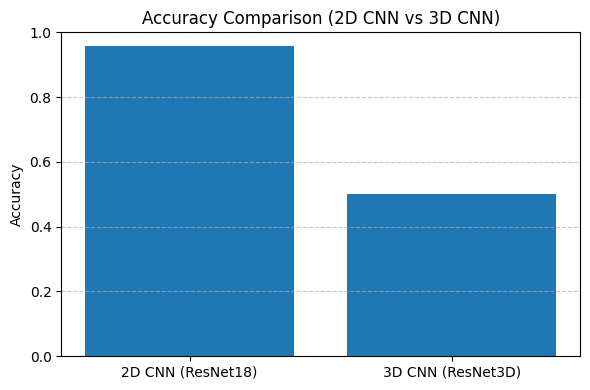

In [26]:
plt.figure(figsize=(6,4))
plt.bar(df_dl_pretty.index, df_dl_pretty["Accuracy"])
plt.title("Accuracy Comparison (2D CNN vs 3D CNN)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "deep_learning_models_accuracy_comparison.png"), dpi=300)
plt.show()
plt.close()

3. Deep Learning Models: F1-score Comparison Plot

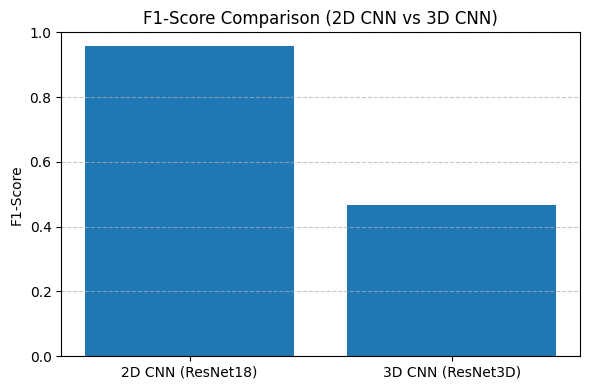

In [27]:
plt.figure(figsize=(6,4))
plt.bar(df_dl_pretty.index, df_dl_pretty["F1-Score"])
plt.title("F1-Score Comparison (2D CNN vs 3D CNN)")
plt.ylabel("F1-Score")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "deep_learning_models_f1_comparison.png"), dpi=300)
plt.show()
plt.close()

4. Deep Learning Models: Precision and Recall grouped Plot

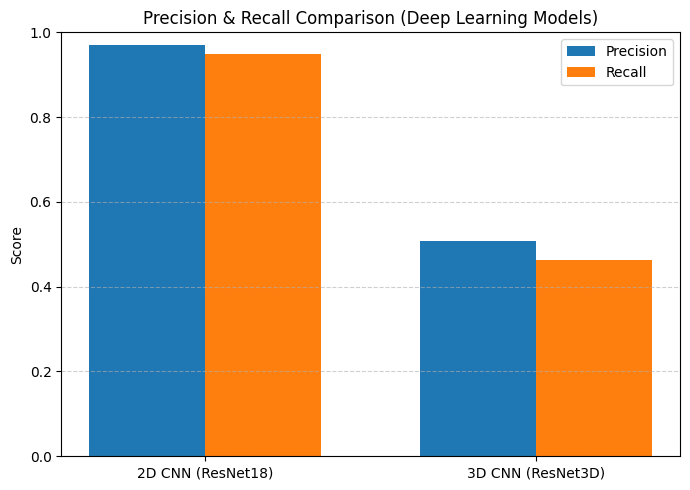

In [28]:
# Extracts all deep learning model names so they can be used as x-axis labels in plots.
models = df_dl_pretty.index.tolist()

# Fetching precision and recall score
precision = df_dl_pretty["Precision"].values
recall = df_dl_pretty["Recall"].values

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, precision, width, label="Precision")
plt.bar(x + width/2, recall, width, label="Recall")

plt.xticks(x, models)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Precision & Recall Comparison (Deep Learning Models)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(
    os.path.join(PLOT_DIR, "deep_learning_precision_recall_comparison.png"),
    dpi=300
)
plt.show()
plt.close()

5. Deep Learning Models: ROC multiclass comparison

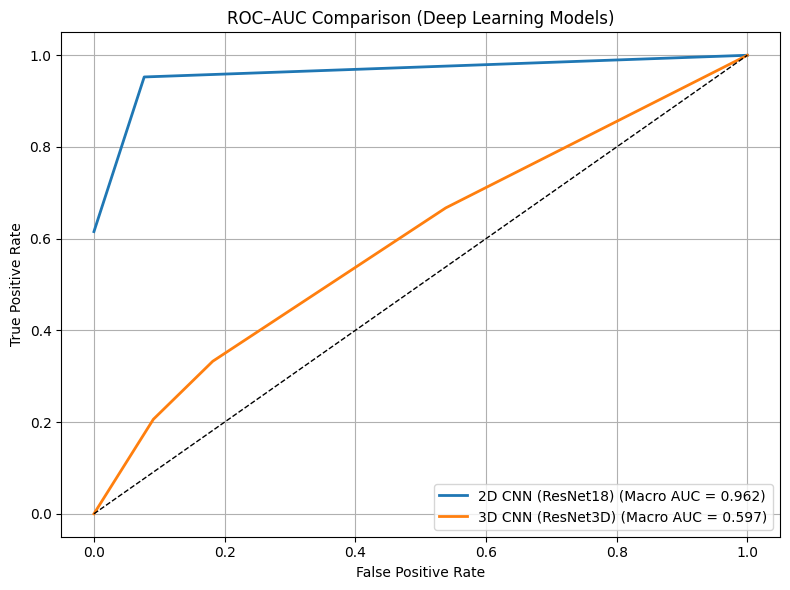

In [29]:
# ===============================
# Basic setup
# ===============================
class_map = {"PullUps": 0, "Punch": 1, "PushUps": 2}
num_classes = len(class_map)
classes = np.arange(num_classes)

models = {
    "2D CNN (ResNet18)": (all_labels_2d, all_preds_2d),
    "3D CNN (ResNet3D)": (all_labels_3d, all_preds_3d),
}

# ===============================
# ROC–AUC Plot
# ===============================
plt.figure(figsize=(8,6))

for model_name, (y_true, y_pred) in models.items():

    y_true_bin = label_binarize(y_true, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)

    fpr, tpr = {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])

    # ----- Macro-average ROC -----
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(
        all_fpr, mean_tpr,
        lw=2,
        label=f"{model_name} (Macro AUC = {macro_auc:.3f})"
    )

# Random baseline
plt.plot([0,1], [0,1], "k--", lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Comparison (Deep Learning Models)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

plt.savefig(
    os.path.join(PLOT_DIR, "deep_learning_roc_auc_comparison.png"),
    dpi=300
)
plt.show()
plt.close()

6. Deep Learning Models: Confusion matrix comparison

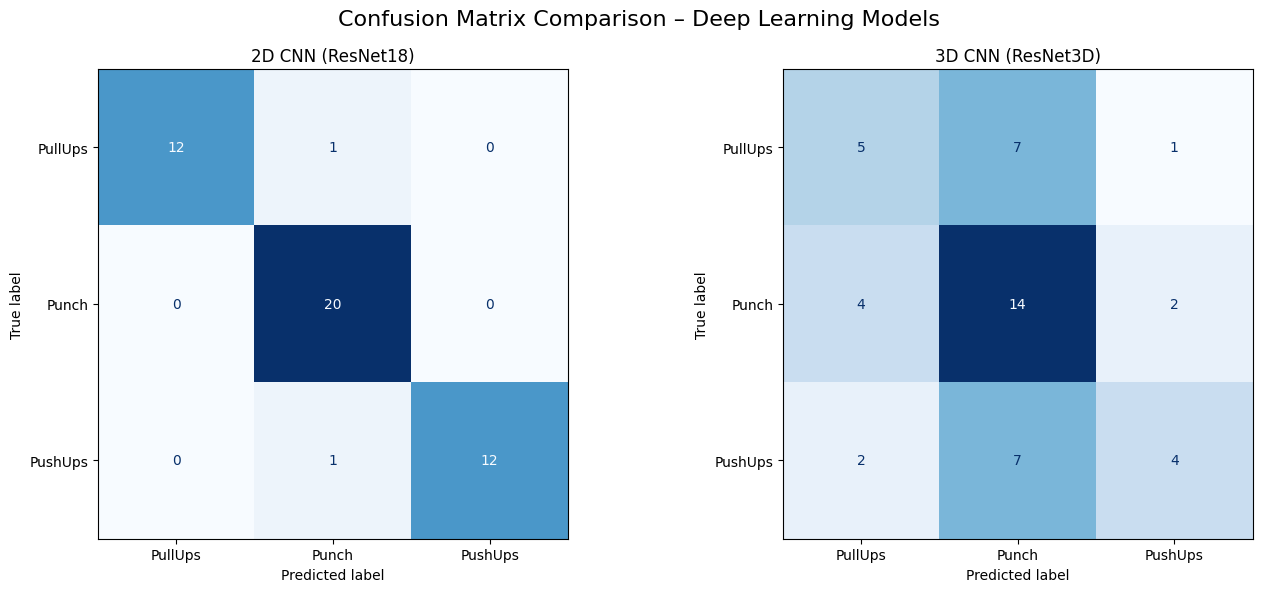

In [30]:
class_map = {"PullUps": 0, "Punch": 1, "PushUps": 2}
class_names = list(class_map.keys())

y_true_2d = np.load("../results/stats_deep_learning/labels_2d.npy")
y_pred_2d = np.load("../results/stats_deep_learning/preds_2d.npy")

y_true_3d = np.load("../results/stats_deep_learning/labels_3d.npy")
y_pred_3d = np.load("../results/stats_deep_learning/preds_3d.npy")

fig, axes = plt.subplots(1, 2, figsize=(14,6))

ConfusionMatrixDisplay.from_predictions(
    y_true_2d, y_pred_2d,
    display_labels=class_names,
    cmap="Blues",
    ax=axes[0],
    colorbar=False
)
axes[0].set_title("2D CNN (ResNet18)")

ConfusionMatrixDisplay.from_predictions(
    y_true_3d, y_pred_3d,
    display_labels=class_names,
    cmap="Blues",
    ax=axes[1],
    colorbar=False
)
axes[1].set_title("3D CNN (ResNet3D)")

fig.suptitle("Confusion Matrix Comparison – Deep Learning Models", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.savefig(
    os.path.join(PLOT_DIR, "deep_learning_confusion_matrix_comparison.png"),
    dpi=300
)
plt.show()
plt.close()

### Deep Learning Models: Comparative Analysis

1. Deep Learning Models: Training time comparison

In [31]:
train_time_2d = np.load("../results/stats_deep_learning/train_time_2d.npy")
train_time_3d = np.load("../results/stats_deep_learning/train_time_3d.npy")

models = ["2D CNN (ResNet18)", "3D CNN (ResNet3D)"]
train_times = [train_time_2d, train_time_3d]

# ===============================
# Table
# ===============================
train_time_df = pd.DataFrame({
    "Model": models,
    "Training Time (seconds)": train_times
})

train_time_df

,Model,Training Time (seconds)
0,2D CNN (ResNet18),3717.864061832428
1,3D CNN (ResNet3D),3936.8292112350464


- Plot: Training time comparison (Deep Learning Models)

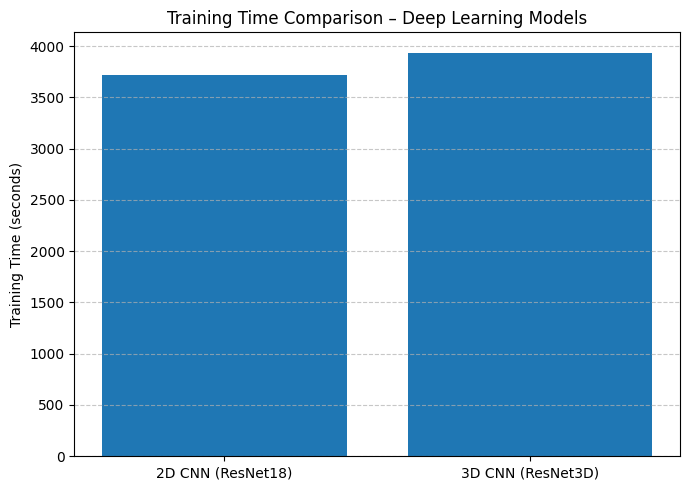

In [32]:

plt.figure(figsize=(7,5))
plt.bar(models, train_times)
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison – Deep Learning Models")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.savefig(
    os.path.join(PLOT_DIR, "deep_learning_training_time_comparison.png"),
    dpi=300
)
plt.show()
plt.close()

2. Deep Learning Models: Inference time per video

In [33]:
inf_time_2d = np.load("../results/stats_deep_learning/inf_time_2d.npy")
inf_time_3d = np.load("../results/stats_deep_learning/inf_time_3d.npy")

df_inf = pd.DataFrame({
    "Model": ["2D CNN (ResNet18)", "3D CNN (ResNet3D)"],
    "Inference Time per Video (s)": [inf_time_2d, inf_time_3d]
})

df_inf



,Model,Inference Time per Video (s)
0,2D CNN (ResNet18),0.48804086446762085
1,3D CNN (ResNet3D),1.2606686353683472


- Plot: Inference time per video (Deep Learning Models)

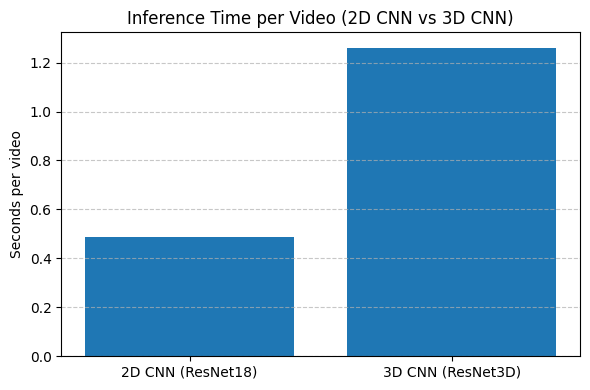

In [34]:
plt.figure(figsize=(6,4))
plt.bar(df_dl_pretty.index, df_dl_pretty["Inference time (s/video)"])
plt.title("Inference Time per Video (2D CNN vs 3D CNN)")
plt.ylabel("Seconds per video")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "deep_learning_models_inference_time_comparison.png"), dpi=300)
plt.show()
plt.close()

3. Deep Learning Models: Model Size Comparison

In [35]:
size_2d = np.load("../results/stats_deep_learning/model_size_2d.npy")
size_3d = np.load("../results/stats_deep_learning/model_size_3d.npy")

df_size = pd.DataFrame({
    "Model": ["2D CNN (ResNet18)", "3D CNN (ResNet3D)"],
    "Model Size (MB)": [size_2d, size_3d]
})

df_size


,Model,Model Size (MB)
0,2D CNN (ResNet18),42.71772289276123
1,3D CNN (ResNet3D),126.60291576385498


- Plot: Model Size Comparison (Deep Learning Models)

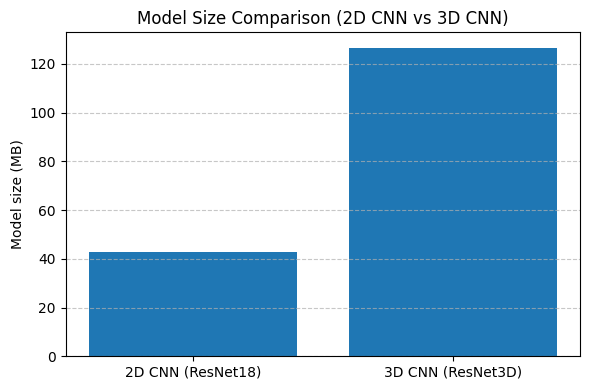

In [36]:
plt.figure(figsize=(6,4))
plt.bar(df_dl_pretty.index, df_dl_pretty["Model size (MB)"])
plt.title("Model Size Comparison (2D CNN vs 3D CNN)")
plt.ylabel("Model size (MB)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "deep_learning_models_size_comparison.png"), dpi=300)
plt.show()
plt.close()

4. Deep Learning Models: Data Efficiency Analysis

In [37]:
# ---------------- Transforms ----------------
train_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ---------------- Setup ----------------
class_map = {"PullUps": 0, "Punch": 1, "PushUps": 2}
num_classes = len(class_map)
dataset_root = "../dataset_info/dataset"
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- Datasets ----------------
train_ds_2d = VideoDataset2D(
    "../dataset_info/dataset/splits/train.csv",
    dataset_root, class_map,
    num_frames=16,
    transform=train_tfms,
    train=True
)

train_ds_3d = VideoDataset3D(
    "../dataset_info/dataset/splits/train.csv",
    dataset_root, class_map,
    num_frames=16,
    transform=train_tfms,   # applied per-frame internally (ok)
    train=True
)


#............ Models .............
model_2d = ResNet18Temporal(num_classes=num_classes, pooling="avg", dropout=0.5).to(device)
model_3d = ResNet3D(num_classes=num_classes, dropout=0.5, freeze_backbone=True).to(device)

# ---------------- Fractions ----------------
fractions = [0.1, 0.25, 0.5, 0.75, 0.9]

learning_results_dl = {
    "2D CNN (ResNet18)": [],
    "3D CNN (ResNet3D)": []
}

# ---------------- Eval helper (with tqdm) ----------------
def evaluate_model(model, loader, device, desc="Evaluating"):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in tqdm(loader, desc=desc, leave=False):
            x, y = x.to(device), y.to(device)
            preds = torch.argmax(model(x), dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


# ---------------- Data Efficiency Loop ----------------
np.random.seed(42)
indices = np.arange(len(train_ds_2d))   # same CSV → safe

for frac in fractions:
    print(f"\n==== Using {int(frac*100)}% training data ====")

    sub_size = int(len(indices) * frac)
    sub_idx = np.random.choice(indices, sub_size, replace=False)

    subset_2d = Subset(train_ds_2d, sub_idx)
    subset_3d = Subset(train_ds_3d, sub_idx)

    loader_2d = DataLoader(
        subset_2d,
        batch_size=4,
        shuffle=True,
        num_workers=4
    )

    loader_3d = DataLoader(
        subset_3d,
        batch_size=2,
        shuffle=True,
        num_workers=4
    )

    acc_2d = evaluate_model(
        model_2d, loader_2d, device,
        desc=f"Eval 2D @ {int(frac*100)}%"
    )

    acc_3d = evaluate_model(
        model_3d, loader_3d, device,
        desc=f"Eval 3D @ {int(frac*100)}%"
    )

    learning_results_dl["2D CNN (ResNet18)"].append(acc_2d)
    learning_results_dl["3D CNN (ResNet3D)"].append(acc_3d)

    print(f"2D Acc: {acc_2d:.4f} | 3D Acc: {acc_3d:.4f}")


# ---------------- Save once ----------------
os.makedirs("../results/stats_deep_learning", exist_ok=True)
np.save(
    "../results/stats_deep_learning/learning_results_dl.npy",
    learning_results_dl,
    allow_pickle=True
)



==== Using 10% training data ====


2D Acc: 0.2593 | 3D Acc: 0.3333

==== Using 25% training data ====


2D Acc: 0.2388 | 3D Acc: 0.4030

==== Using 50% training data ====


2D Acc: 0.2889 | 3D Acc: 0.3259

==== Using 75% training data ====


2D Acc: 0.2660 | 3D Acc: 0.3300

==== Using 90% training data ====


2D Acc: 0.2757 | 3D Acc: 0.3169


Plot: Learning curves comparison (Deep Learning Models)

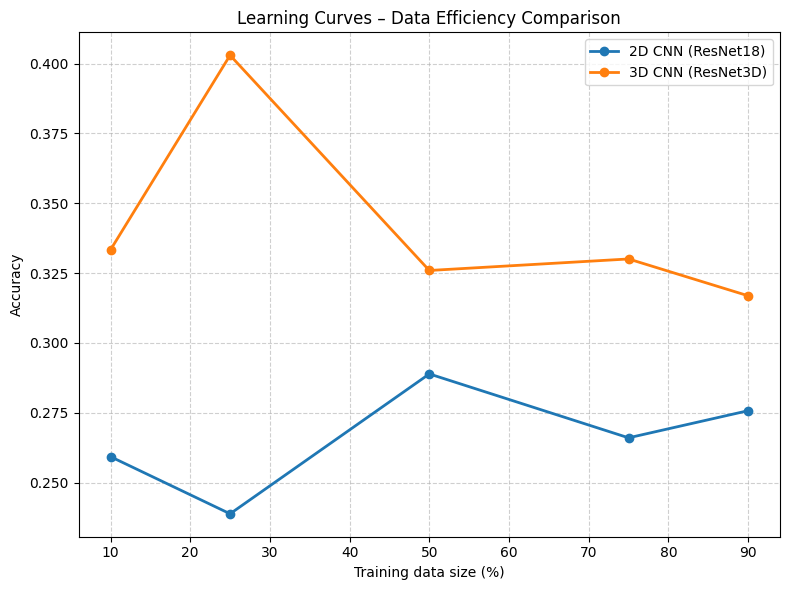

In [38]:
plt.figure(figsize=(8,6))

for model_name, accs in learning_results_dl.items():
    plt.plot(
        [int(f*100) for f in fractions],
        accs,
        marker="o",
        linewidth=2,
        label=model_name
    )

plt.xlabel("Training data size (%)")
plt.ylabel("Accuracy")
plt.title("Learning Curves – Data Efficiency Comparison");
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.path.join(PLOT_DIR, "data_efficiency_learning_curves.png"), dpi=300);

plt.show()
plt.close()


5. Deep Learning Models: Memory requirements

In [39]:
dummy_2d = torch.randn(1, 16, 3, 224, 224).to(device)
dummy_3d = torch.randn(1, 3, 16, 224, 224).to(device)

dummy_inputs = {
    "2D CNN (ResNet18)": dummy_2d,
    "3D CNN (ResNet3D)": dummy_3d
}

memory_results_dl = []

models = {
    "2D CNN (ResNet18)": model_2d,
    "3D CNN (ResNet3D)": model_3d
}

for name, model in models.items():
    tracemalloc.start()

    model.eval()
    with torch.no_grad():
        _ = model(dummy_inputs[name])

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    memory_results_dl.append([
        name,
        peak / (1024 * 1024)   # MB
    ])

memory_df_dl = pd.DataFrame(
    memory_results_dl,
    columns=["Model", "Peak Memory Usage (MB)"]
)

memory_df_dl


,Model,Peak Memory Usage (MB)
0,2D CNN (ResNet18),0.005135
1,3D CNN (ResNet3D),0.004646


- Plot: Memory requirements (Deep Learning Models)

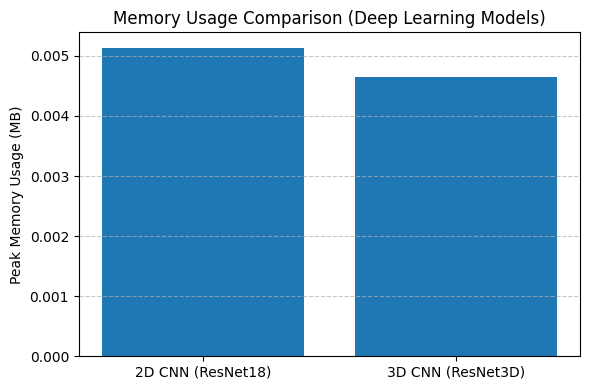

In [40]:

plt.figure(figsize=(6,4))
plt.bar(memory_df_dl["Model"], memory_df_dl["Peak Memory Usage (MB)"])
plt.ylabel("Peak Memory Usage (MB)")
plt.title("Memory Usage Comparison (Deep Learning Models)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(PLOT_DIR, "deep_learning_memory_usage_comparison.png"), dpi=300)

plt.show()
plt.close()

6. Deep Learning Models: t-SNE Visualization (Feature Analysis)

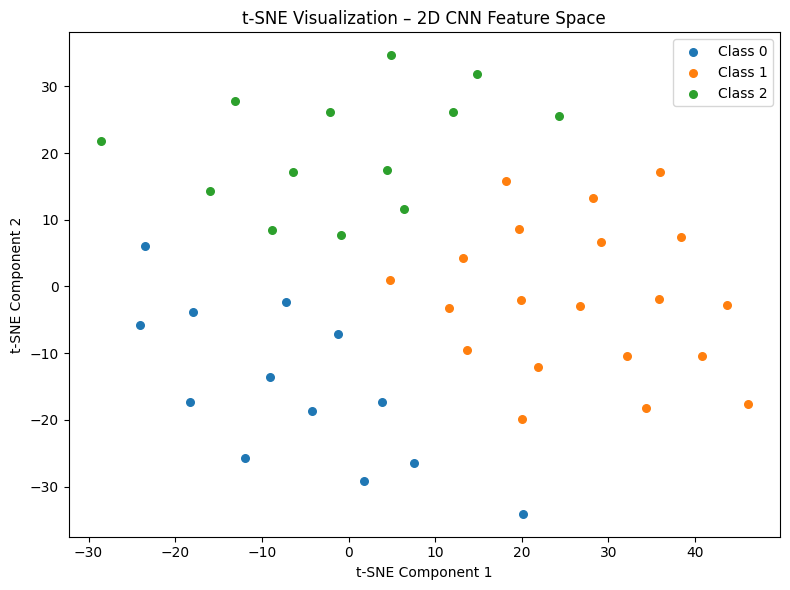

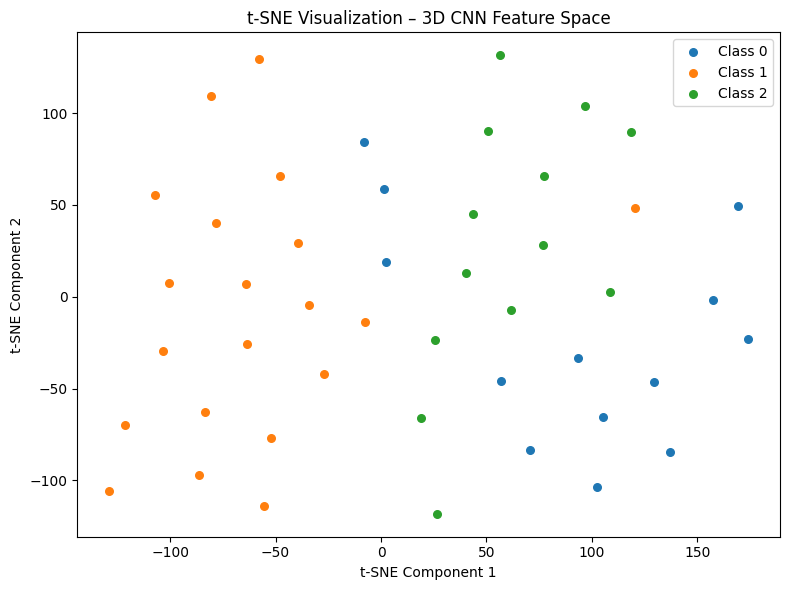

In [41]:

# ================== CONFIG ==================
val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

class_map = {"PullUps": 0, "Punch": 1, "PushUps": 2}
dataset_root = "../dataset_info/dataset"

# ================== LOAD TEST DATA ==================

# ---------- 2D ----------
test_ds_2d = VideoDataset2D(
    "../dataset_info/dataset/splits/test.csv",
    dataset_root,
    class_map,
    num_frames=16,
    transform=val_tfms,
    train=False
)

test_loader_2d = DataLoader(
    test_ds_2d,
    batch_size=4,
    shuffle=False,
    num_workers=4
)

# ---------- 3D ----------
test_ds_3d = VideoDataset3D(
    "../dataset_info/dataset/splits/test.csv",
    dataset_root,
    class_map,
    num_frames=16,
    transform=val_tfms,
    train=False
)

test_loader_3d = DataLoader(
    test_ds_3d,
    batch_size=2,
    shuffle=False,
    num_workers=4
)

# ================== FEATURE EXTRACTION ==================

def extract_features_2d(model, loader, device):
    model.eval()
    feats, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)   # (B,T,C,H,W)

            B, T, C, H, W = x.shape
            x = x.view(B*T, C, H, W)

            f = model.feature_extractor(x)
            f = f.squeeze(-1).squeeze(-1)     # (B*T,512)
            f = f.view(B, T, -1).mean(dim=1)  # temporal pooling

            feats.append(f.cpu().numpy())
            labels.append(y.numpy())

    return np.vstack(feats), np.hstack(labels)


def extract_features_3d(model, loader, device):
    model.eval()
    feats, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)   # (B,C,T,H,W)
            f = model.backbone(x)   # already pooled (B,512)
            feats.append(f.cpu().numpy())
            labels.append(y.numpy())

    return np.vstack(feats), np.hstack(labels)


# ================== RUN EXTRACTION ==================

X_2d, y_2d = extract_features_2d(model_2d, test_loader_2d, device)
X_3d, y_3d = extract_features_3d(model_3d, test_loader_3d, device)

# ================== t-SNE PLOT ==================

def tsne_plot(X, y, title, save_path):
    X = StandardScaler().fit_transform(X)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        max_iter=1500,
        random_state=42
    )

    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(8,6))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(
            X_tsne[idx, 0],
            X_tsne[idx, 1],
            s=30,
            label=f"Class {label}"
        )

    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()


# ================== GENERATE PLOTS ==================

tsne_plot(
    X_2d, y_2d,
    title="t-SNE Visualization – 2D CNN Feature Space",
    save_path="../results/feature_visualizations/tsne_umap/tsne_2d_cnn.png"
)

tsne_plot(
    X_3d, y_3d,
    title="t-SNE Visualization – 3D CNN Feature Space",
    save_path="../results/feature_visualizations/tsne_umap/tsne_3d_cnn.png"
)


7. Deep Learning Models: UMAP Visualization (Feature Analysis)

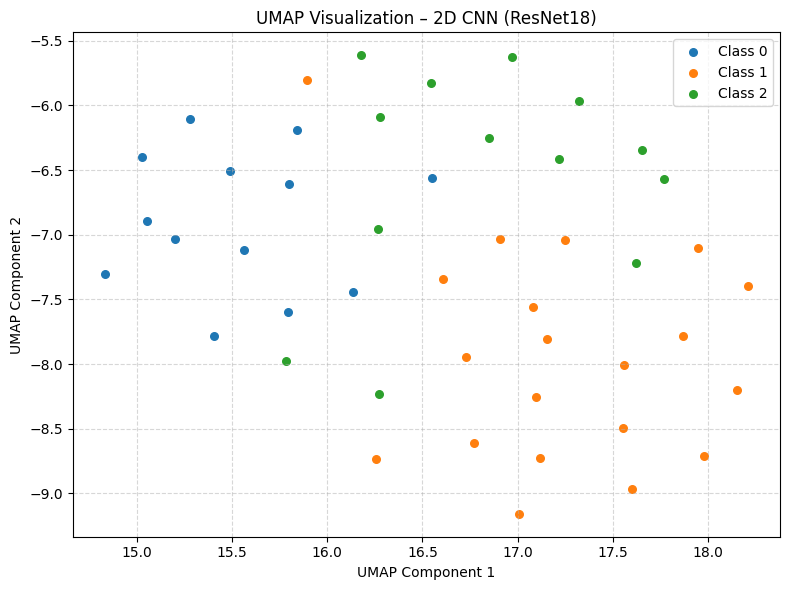

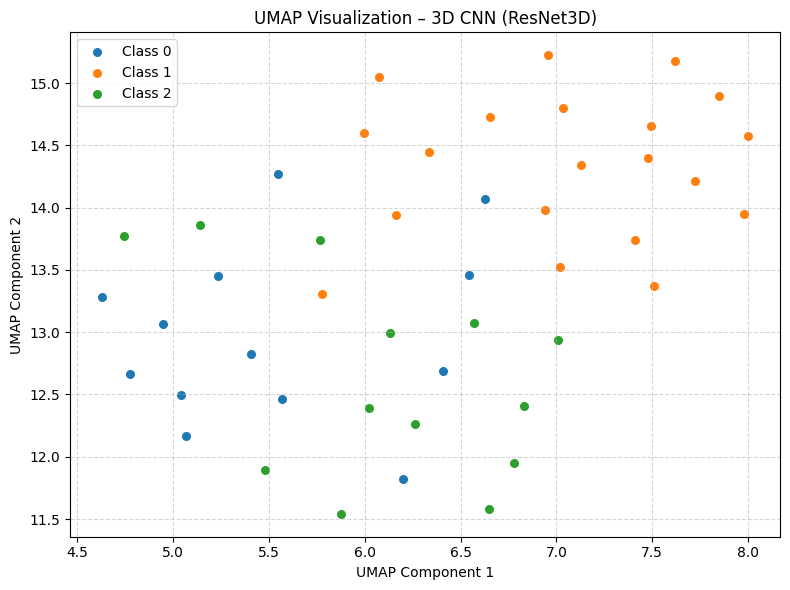

In [42]:
def umap_plot(X, y, title, save_path):
    # Normalize features
    X_scaled = StandardScaler().fit_transform(X)

    # UMAP
    umap_model = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        random_state=42
    )

    X_umap = umap_model.fit_transform(X_scaled)

    # Plot
    plt.figure(figsize=(8,6))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(
            X_umap[idx, 0],
            X_umap[idx, 1],
            s=30,
            label=f"Class {label}"
        )

    plt.title(title)
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

umap_plot(
    X_2d,
    y_2d,
    title="UMAP Visualization – 2D CNN (ResNet18)",
    save_path="../results/feature_visualizations/tsne_umap/umap_2d_cnn.png"
)

umap_plot(
    X_3d,
    y_3d,
    title="UMAP Visualization – 3D CNN (ResNet3D)",
    save_path="../results/feature_visualizations/tsne_umap/umap_3d_cnn.png"
)